# Coronavirus
Statistics about coronavirus in Czechia.  
Filip Gregor, 2020 

In [61]:
tests = "https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/testy.csv"
cases = "https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/nakaza.csv"
patients = "https://onemocneni-aktualne.mzcr.cz/api/v1/covid-19/osoby.csv"

Import python libraries

In [62]:
import pandas as pd

Read the data and save them into panda dataframe.

In [66]:
df_tests = pd.read_csv(tests)
# Translate column headers into english. 
df_tests = df_tests.rename({
    'datum' : 'date',
    'testy_den' : 'daily_tests',
    'testy_celkem' : 'all_time_tests'
}, axis = 1)
df_tests.tail()

,date,daily_tests,all_time_tests
184,2020-07-29,7295,683613
185,2020-07-30,7516,691129
186,2020-07-31,8110,699239
187,2020-08-01,4651,703890
188,2020-08-02,2571,706461


In [67]:
df_cases = pd.read_csv(cases)
df_cases = df_cases.rename({
    'datum' : 'date',
    'pocet_den' : 'daily_cases',
    'pocet_celkem' : 'positive'
}, axis = 1)
df_cases.tail()


,date,daily_cases,positive
185,2020-07-30,252,16341
186,2020-07-31,231,16572
187,2020-08-01,124,16696
188,2020-08-02,102,16798
189,2020-08-03,210,17008


Create a dataframe named 'corona' which has rows containing daily test cases and positive cases in that day, and all positive cases.  
Also delete leading rows which has 0 positive cases.

In [100]:
corona = pd.DataFrame(data = {
    'date' : df_cases.date,
    'daily_cases' : df_cases.daily_cases,
    'tests' : df_tests.all_time_tests,
    'positive' : df_cases.positive,
})
corona = corona[:-1]
# Last row often has missing values in df_tests, so just remove it. 
corona.tail()

,date,daily_cases,tests,positive
184,2020-07-29,274,683613.0,16089
185,2020-07-30,252,691129.0,16341
186,2020-07-31,231,699239.0,16572
187,2020-08-01,124,703890.0,16696
188,2020-08-02,102,706461.0,16798


In [90]:
# Convert date to datetype 
corona['date'] = pd.to_datetime(corona['date'], format='%Y-%m-%d')
# Sort values by date and reset indexes
corona.sort_values('date')
corona.reset_index(drop=True)
corona.tail()

,date,daily_cases,daily_tests,positive
184,2020-07-29,274,7295.0,16089
185,2020-07-30,252,7516.0,16341
186,2020-07-31,231,8110.0,16572
187,2020-08-01,124,4651.0,16696
188,2020-08-02,102,2571.0,16798


In [88]:
corona_Pmask = corona['daily_cases'] > 0

# Count how many leading rows have 0 cases, stop when we encounter a row that has cases.
count = 0
for x in corona_Pmask:
    if x:
        break
    count += 1
    
corona = corona.iloc[count:]
corona.head()

,date,daily_cases,daily_tests,positive
34,2020-03-01,3,11.0,3
35,2020-03-02,0,51.0,3
36,2020-03-03,2,78.0,5
37,2020-03-04,1,67.0,6
38,2020-03-05,3,76.0,9


# Simple Graphs

Positive cases

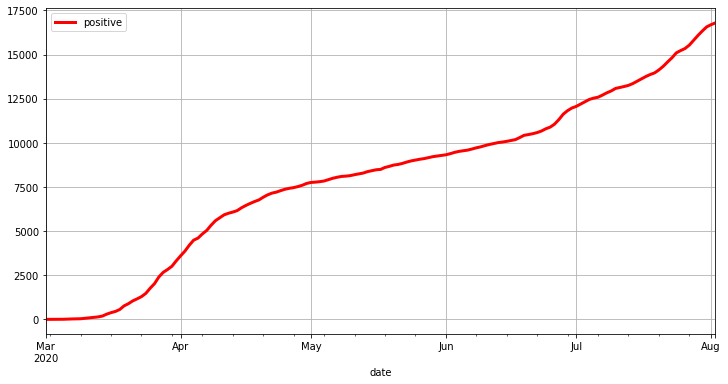

In [99]:
pl = corona.plot(x='date', y='positive', figsize=(12,6), grid=True, lw=3, color='red')

Tests done.

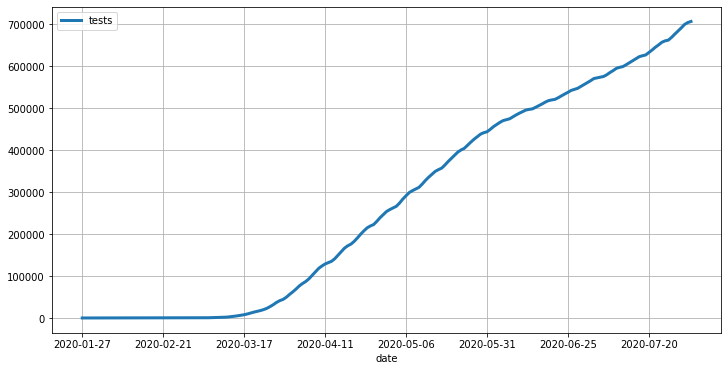

In [102]:
pl = corona.plot(x='date', y='tests', figsize=(12,6), grid=True, lw=3)